<div style="background-color: #56B4E9; padding: 20px; border-radius: 20px; color: #ffffff">
  <h1><strong>LABcal: Automated Calendar Analysis for the Education Lab »ExpLAB« at the University Library Mannheim</strong></h1>
  <h3>Final Project in the Data Librarian Certificate Course 2023/24</h3>
  <h4><strong>Code demo</strong></h4>
  <p>Thomas Schmidt (University of Mannheim | University Library)</p>
  <ul>
    <li>E-Mail: <a href="mailto:thomas.schmidt@uni-mannheim.de">thomas.schmidt@uni-mannheim.de</a></li>
    <li>ORCID: <a href="https://orcid.org/0000-0003-3620-3355">0000-0003-3620-3355</a></li>
  </ul>
</div>

### **Annotated Code**

#### Install dependencies and import packages

In [1]:
# Install dependencies if necessary
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Main labcal package for data processing and plotting
from labcal import process_cal, plot_cal

# Set .svg as file format for all plots
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Use seaborn theme for plots
import seaborn as sns
sns.set_theme(style='whitegrid')

%matplotlib inline

#### **Step 1: Data Parsing**

The parsing of the calendar is done using the open-source Python package `ics.py`. The `ics.Event` objects serialised as `str` are converted into a Python `dict`, where the typical `.ics` data structure is split into key-value pairs. The `dict` created is then transferred into a Pandas `DataFrame`.

The main functions for data parsing are:

* `process_cal.load_and_parse_calendar()`
* `process_cal.create_dataframe_from_calendar()`

##### Load and parse the calendar

In [3]:
cal = process_cal.load_and_parse_calendar(filepath='./data/dummy_cal.ics')
cal

<Calendar with 53 events and 0 todo>

##### Create a `pd.DataFrame`
You can set the `verbose` paramenter to `True` for detailed processing logs.

In [4]:
df = process_cal.create_dataframe_from_calendar(cal=cal, verbose=False)

##### Inspect the `DataFrame`

In [5]:
df.head()

,BEGIN,UID,END,X-MOZ-LASTACK,SEQUENCE,STATUS,LAST-MODIFIED,TRIGGER,CREATED,DTSTAMP,DESCRIPTION,SUMMARY,DTSTART,ACTION,DTEND,TRANSP,X-MOZ-GENERATION
0,VEVENT,929d73ba-ed51-4cad-8191-8901f6249195,VEVENT,None,5,CONFIRMED,20240415T065031Z,None,20240408T083347Z,20240415T065031Z,Kategorie Veranstaltung: Culture Games ¶Verans...,Culture Games,20240423T180000Z,None,20240423T203000Z,None,None
1,VEVENT,06ef3ad9-82c1-4e91-bce9-2e494c448f38,VEVENT,None,3,CONFIRMED,20240227T072808Z,None,20240220T111813Z,20240227T072808Z,Kategorie Veranstaltung: Testlab Working Sessi...,Testlab Working Session,20240220T170000Z,None,20240220T210000Z,None,None
2,VEVENT,614fb975-c3d7-45b8-9830-a8fca54730b0,VEVENT,None,7,CONFIRMED,20240423T112444Z,None,20240411T085512Z,20240423T112444Z,Kategorie Veranstaltung: Staff Meeting¶Veranst...,Staff Meeting,20241024T060000Z,None,20241024T160000Z,None,None
3,VEVENT,3ba0fe71-4255-4f10-9313-b107589def62,VEVENT,None,3,CONFIRMED,20231222T075126Z,None,20231222T074911Z,20231222T075126Z,Kategorie Workshop: Yoga und Meditation¶Verans...,Sport Yoga,20240110T111500Z,None,20240110T120000Z,None,None
4,VEVENT,940dbc83-df6a-4bd2-9753-673af96a10c5,VEVENT,None,2,CONFIRMED,20240610T082846Z,None,20240610T082820Z,20240610T082846Z,Kategorie Workshop: Yoga und Meditation ¶Veran...,Sport Yoga,20240729T094500Z,None,20240729T104500Z,None,None


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   BEGIN             53 non-null     object
 1   UID               53 non-null     object
 2   END               53 non-null     object
 3   X-MOZ-LASTACK     1 non-null      object
 4   SEQUENCE          53 non-null     object
 5   STATUS            51 non-null     object
 6   LAST-MODIFIED     53 non-null     object
 7   TRIGGER           1 non-null      object
 8   CREATED           53 non-null     object
 9   DTSTAMP           53 non-null     object
 10  DESCRIPTION       53 non-null     object
 11  SUMMARY           53 non-null     object
 12  DTSTART           53 non-null     object
 13  ACTION            1 non-null      object
 14  DTEND             53 non-null     object
 15  TRANSP            2 non-null      object
 16  X-MOZ-GENERATION  2 non-null      object
dtypes: object(17)
memo

In [7]:
df.columns

Index(['BEGIN', 'UID', 'END', 'X-MOZ-LASTACK', 'SEQUENCE', 'STATUS',
       'LAST-MODIFIED', 'TRIGGER', 'CREATED', 'DTSTAMP', 'DESCRIPTION',
       'SUMMARY', 'DTSTART', 'ACTION', 'DTEND', 'TRANSP', 'X-MOZ-GENERATION'],
      dtype='object')

In [8]:
df.shape

(53, 17)

#### **Step 2: Data Cleaning**

The `process_cal.clean_calendar_dataframe()` function cleans various aspects of the `DataFrame` step by step, including removing columns with less than 5% non-null values, rearranging the column layout for easier data access, and, importantly, data cleaning for the `event_desc_list` column, where the information from the calendar’s `DESCRIPTION` field is stored in a `list[str]` structure.

Using the `process_cal.process_description()` function, these list elements are further processed. The function iterates through all list elements and matches certain `str` sequences (e.g., `Kategorie`, `Veranstalter`, and `Teilnehmer`, etc.). When a specific string (e.g., `Kategorie`) is found, a separate function (in this case, `process_cal.clean_event_category()`) takes over the processing, which consists of a `dict` mapping.

The main function for data cleaning is:

* `process_cal.clean_calendar_dataframe()`

Refer to this function for further documentation.

##### Clean the `DataFrame`

In [9]:
clean_df = process_cal.clean_calendar_dataframe(df)

In [10]:
clean_df.head()

,id,created,event_title,event_start,event_end,event_category,event_description,event_desc_list,event_desc,organiser,organiser_detail,participant_count,equip,equip_clevertouch,equip_dt,equip_eyetracking,equip_monitor,equip_vr,catering,notes
0,929d73ba-ed51-4cad-8191-8901f6249195,2024-04-08 08:33:47+00:00,Culture Games,2024-04-23 18:00:00+00:00,2024-04-23 20:30:00+00:00,Veranstaltung,Culture Games,"[Kategorie Veranstaltung: Culture Games , Vera...",Kategorie Veranstaltung: Culture Games ¶Verans...,Uni,Social Science,25,False,False,False,False,False,False,False,2 Tische bereit stellen
1,06ef3ad9-82c1-4e91-bce9-2e494c448f38,2024-02-20 11:18:13+00:00,Testlab Working Session,2024-02-20 17:00:00+00:00,2024-02-20 21:00:00+00:00,Veranstaltung,Testlab Working Session,[Kategorie Veranstaltung: Testlab Working Sess...,Kategorie Veranstaltung: Testlab Working Sessi...,Studis,Stud.-Initiative Y,20,True,False,False,False,True,False,False,None
2,614fb975-c3d7-45b8-9830-a8fca54730b0,2024-04-11 08:55:12+00:00,Staff Meeting,2024-10-24 06:00:00+00:00,2024-10-24 16:00:00+00:00,Veranstaltung,Staff Meeting,"[Kategorie Veranstaltung: Staff Meeting, Veran...",Kategorie Veranstaltung: Staff Meeting¶Veranst...,Uni,Study Center,15,True,True,True,False,True,False,True,"Technikbedarf folgt, wenn ext. DozentIn festge..."
3,3ba0fe71-4255-4f10-9313-b107589def62,2023-12-22 07:49:11+00:00,Sport Yoga,2024-01-10 11:15:00+00:00,2024-01-10 12:00:00+00:00,Workshop,Yoga und Meditation,"[Kategorie Workshop: Yoga und Meditation, Vera...",Kategorie Workshop: Yoga und Meditation¶Verans...,Uni,Institut für Sport,10,False,False,False,False,False,False,False,None
4,940dbc83-df6a-4bd2-9753-673af96a10c5,2024-06-10 08:28:20+00:00,Sport Yoga,2024-07-29 09:45:00+00:00,2024-07-29 10:45:00+00:00,Workshop,Yoga und Meditation,"[Kategorie Workshop: Yoga und Meditation , Ver...",Kategorie Workshop: Yoga und Meditation ¶Veran...,Uni,Institut für Sport,10,False,False,False,False,False,False,False,None


In [11]:
clean_df.shape

(53, 20)

In [12]:
clean_df.columns

Index(['id', 'created', 'event_title', 'event_start', 'event_end',
       'event_category', 'event_description', 'event_desc_list', 'event_desc',
       'organiser', 'organiser_detail', 'participant_count', 'equip',
       'equip_clevertouch', 'equip_dt', 'equip_eyetracking', 'equip_monitor',
       'equip_vr', 'catering', 'notes'],
      dtype='object')

In [13]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   id                 53 non-null     object             
 1   created            53 non-null     datetime64[ns, UTC]
 2   event_title        53 non-null     object             
 3   event_start        53 non-null     datetime64[ns, UTC]
 4   event_end          53 non-null     datetime64[ns, UTC]
 5   event_category     53 non-null     object             
 6   event_description  53 non-null     object             
 7   event_desc_list    53 non-null     object             
 8   event_desc         53 non-null     object             
 9   organiser          53 non-null     object             
 10  organiser_detail   53 non-null     object             
 11  participant_count  53 non-null     int16              
 12  equip              53 non-null     bool             

#### **Step 3: Data Visualisation**

In [14]:
# List available plotting functions
plot_cal.plot_calendar(list_func=True)

Available plotting functions: ['organiser', 'organiser_detail', 'event_category', 'event_category_by_organiser', 'equip_details', 'equip_overall', 'participant_stats', 'participants_per_month']


Plot all available visualisations for the time period '01.01.2024' - '31.12.2024'

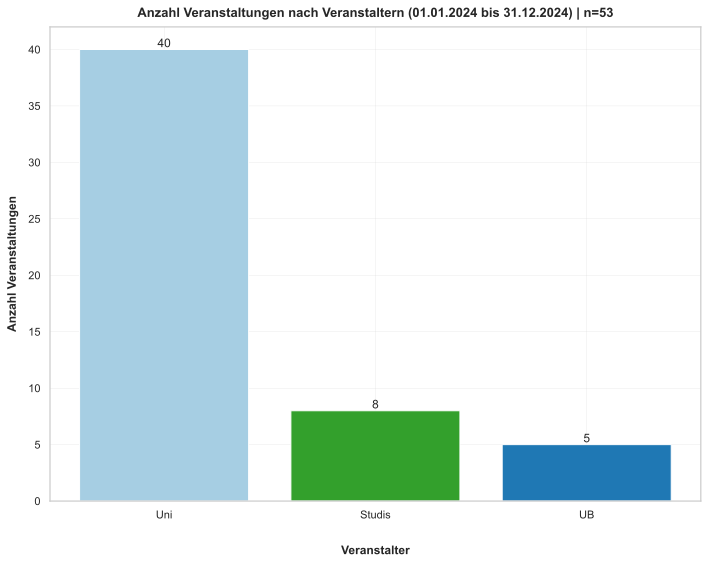

In [15]:
# func='organiser'
plot_cal.plot_calendar(clean_df, 
                       start_date='01.01.2024', 
                       end_date='31.12.2024',
                       func='organiser')

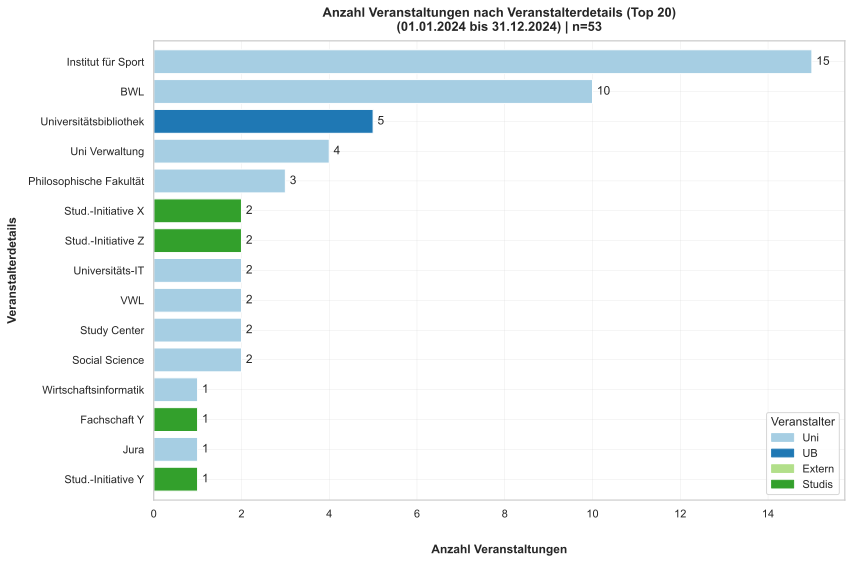

In [16]:
# func='organiser_detail'
plot_cal.plot_calendar(clean_df, 
                       start_date='01.01.2024', 
                       end_date='31.12.2024',
                       func='organiser_detail',
                       top_k=20) # plot top 20 organisers

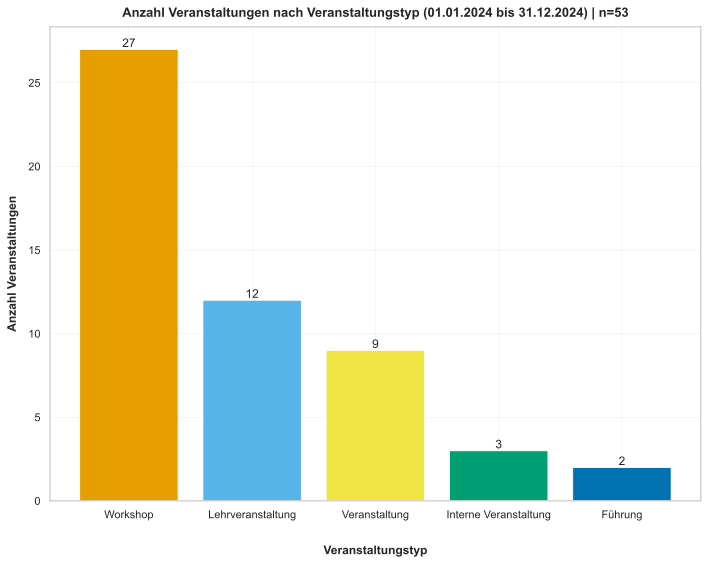

In [17]:
# func='event_category'
plot_cal.plot_calendar(clean_df, 
                       start_date='01.01.2024', 
                       end_date='31.12.2024',
                       func='event_category')

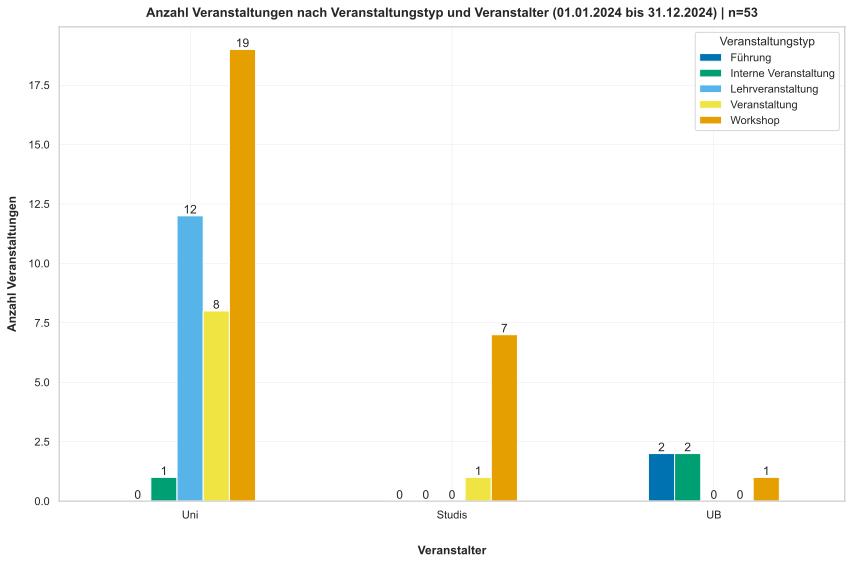

In [18]:
# func='event_category_by_organiser'
plot_cal.plot_calendar(clean_df, 
                       start_date='01.01.2024', 
                       end_date='31.12.2024',
                       func='event_category_by_organiser')

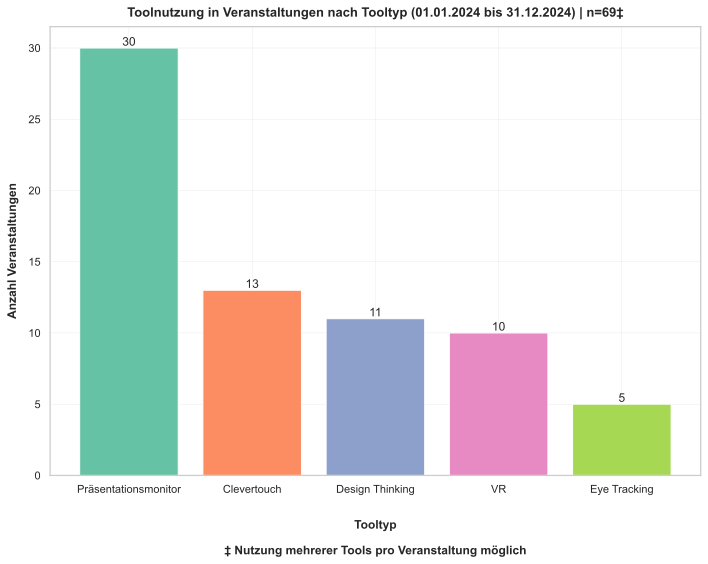

In [19]:
# func='equip_details'
plot_cal.plot_calendar(clean_df, 
                       start_date='01.01.2024', 
                       end_date='31.12.2024',
                       func='equip_details')

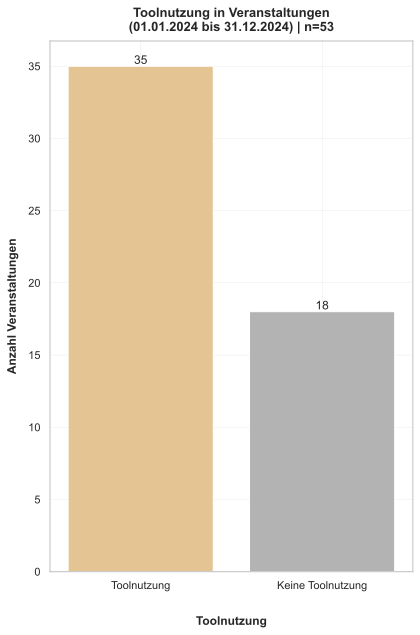

In [20]:
# func='equip_overall'
plot_cal.plot_calendar(clean_df, 
                       start_date='01.01.2024', 
                       end_date='31.12.2024',
                       func='equip_overall')

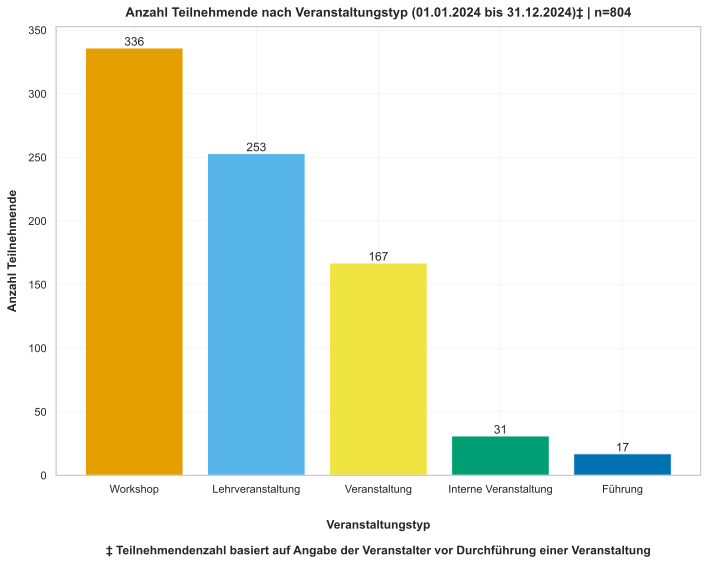

In [21]:
# func='participant_stats'
plot_cal.plot_calendar(clean_df, 
                       start_date='01.01.2024', 
                       end_date='31.12.2024',
                       func='participant_stats')

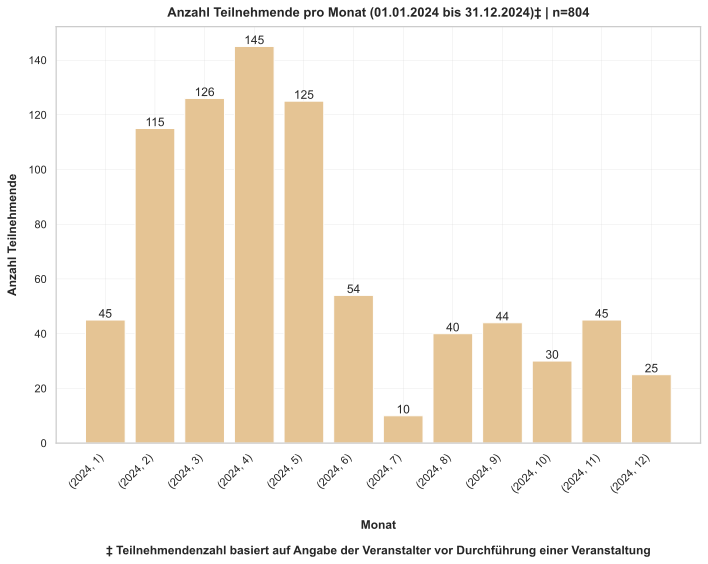

In [22]:
# func='participants_per_month'
plot_cal.plot_calendar(clean_df, 
                       start_date='01.01.2024', 
                       end_date='31.12.2024',
                       func='participants_per_month')

#### **Step 4: Streamlit web application**

Start the `streamlit` web application:

In [24]:
!streamlit run app.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.2.110:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
^C
  Stopping...
